In [1]:
#lpips 
import lpips
import os
from PIL import Image 
import torch 
from pbw_utils import renormalize, show

lpips_metric = lpips.LPIPS(net='alex')
mse_metric = torch.nn.MSELoss()

#local mean squared error from intrinsic image algorithms
import numpy as np

def local_error(correct, estimate, mask, window_size, window_shift):
    """Returns the sum of the local sum-squared-errors, where the estimate may
    be rescaled within each local region to minimize the error. The windows are
    window_size x window_size, and they are spaced by window_shift."""
    M, N = correct.shape[1:]
    ssq = total = 0.
    for i in range(0, M - window_size + 1, window_shift):
        for j in range(0, N - window_size + 1, window_shift):
            correct_curr = correct[:, i:i+window_size, j:j+window_size]
            estimate_curr = estimate[:, i:i+window_size, j:j+window_size]
            mask_curr = mask[:, i:i+window_size, j:j+window_size]
            ssq += ssq_error(correct_curr, estimate_curr, mask_curr)
        total += np.sum(mask_curr * correct_curr**2)
    assert ~np.isnan(ssq/total)
    return ssq / total

def ssq_error(correct, estimate, mask):
    """Compute the sum-squared-error for an image, where the estimate is
    multiplied by a scalar which minimizes the error. Sums over all pixels
    where mask is True. If the inputs are color, each color channel can be
    rescaled independently."""
    assert correct.ndim == 3
    if np.sum(estimate**2 * mask) > 1e-5:
        alpha = np.sum(correct * estimate * mask) / np.sum(estimate**2 * mask)
    else:
        alpha = 0.
    return np.sum(mask * (correct - alpha*estimate) ** 2)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /afs/csail.mit.edu/u/a/audcui/.conda/envs/pbenv/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [2]:
#test_path = "results/modulated_bedrooms_9resnet/test_230_real_datasets_agata_bedroom_light_all/images/"
test_path = "results/alternate_train_lamp/test_600_real_datasets_agata_light_all_ones/images"
#test_path = '/data/vision/torralba/paintbyword/u/audcui/encoder4editing/results/agata_light_all_e4e'
truth_path = "datasets/agata_light_all/test_B/"

lpips_all = []
mse_all = []
lmse_all = []

def pilim(img): 
    return renormalize.from_image(img)

i = 0
for img_path in os.listdir(truth_path): 
    i+=1
    print(f'{i} {img_path}')
    w, h = (256, 256)
    truth = pilim(Image.open(os.path.join(truth_path, img_path)).resize((h, w), Image.BILINEAR))
    img_path = img_path[4:-4]
    
    #_, w, h = truth.shape
    test = pilim(Image.open(
                os.path.join(test_path, img_path+"_output_image.jpg")).resize((h, w), Image.BILINEAR))
#     original = pilim(Image.open(
#                 os.path.join(test_path, img_path+"_input_image.jpg")).resize((h, w), Image.BILINEAR))
    
    
#     print(original.shape)
    lpips_all.append(torch.squeeze(lpips_metric(test, truth)))
    #lpips_baseline_all.append(torch.squeeze(lpips_metric(original, truth)))
    
    mse_all.append(torch.squeeze(mse_metric(test, truth)))
    #mse_baseline_all.append(torch.squeeze(mse_metric(original, truth)))
    
    mask = np.ones(truth.shape)
    lmse_all.append(local_error(truth.numpy(), test.numpy(), mask, 20, 10))
     
#lpips_baseline_avg = torch.mean(torch.stack(lpips_baseline_all))
#mse_basline_avg = torch.mean(torch.stack(mse_baseline_all))  
lpips_avg = torch.mean(torch.stack(lpips_all))
mse_avg = torch.mean(torch.stack(mse_all))
lmse_avg = sum(lmse_all)/len(lmse_all)
print(f'lpips: {lpips_avg}')
print(f'mse: {mse_avg}')
print(f'lmse: {lmse_avg}')

1 lit_place109_4_light_1.jpg
2 lit_place110_4_light_e.jpg
3 lit_place121_3_light_e1.jpg
4 lit_place111_3_light_2e.jpg
5 lit_place131_3_light_e.jpg
6 lit_place142_2_light_1.jpg
7 lit_place112_2_light_e.jpg
8 lit_place110_4_light_123.jpg
9 lit_place100_3_light_1.jpg
10 lit_place12_2_light_1.jpg
11 lit_place134_3_light_e.jpg
12 lit_place120_3_light_e.jpg
13 lit_place134_3_light_2e.jpg
14 lit_place101_3_light_2.jpg
15 lit_place8_3_light_12.jpg
16 lit_place5_2_light_1.jpg
17 lit_place1_2_light_2.jpg
18 lit_place115_3_light_2.jpg
19 lit_place24_3_light_13.jpg
20 lit_place108_3_light_12.jpg
21 lit_place31_3_light_1.jpg
22 lit_place105_2_light_2.jpg
23 lit_place156_4_light_13e.jpg
24 lit_place109_4_light_23.jpg
25 lit_place1_3_light_12.jpg
26 lit_place21_2_light_1.jpg
27 lit_place1_3_light_1.jpg
28 lit_place123_3_light_2e.jpg
29 lit_place156_4_light_1e.jpg
30 lit_place101_3_light_12.jpg
31 lit_place139_3_light_1e.jpg
32 lit_place145_2_light_e.jpg
33 lit_place31_3_light_12.jpg
34 lit_place130_2

In [ ]:
print(f'lpips: {lpips_avg}')
print(f'mse: {mse_avg}')
print(f'lpips baseline: {lpips_baseline_avg}')
print(f'mse baseline: {mse_basline_avg}')

In [5]:
mask = np.ones(truth.shape)
lmse = local_error(truth.numpy(), test.numpy(), mask, 20, 10)
print(lmse)
lmse = local_error(truth.numpy(), original.numpy(), mask, 20, 10)
print(lmse)

NameError: name 'truth' is not defined

In [64]:
import cv2

def get_edges_canny(im): 
    im = cv2.cvtColor(np.array(im).reshape(256, 256, 3), cv2.COLOR_BGR2GRAY)

    im = cv2.Canny(image=np.uint8(im), threshold1=100, threshold2=200)
    im = cv2.convertScaleAbs(im, alpha=255/im.max())
    im = torch.tensor(im/255).unsqueeze(0).repeat(3, 1, 1).float() #dimension of (3, 256, 256) needed for lpips
    return im


0


,,

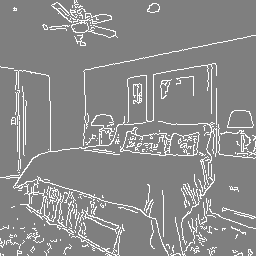
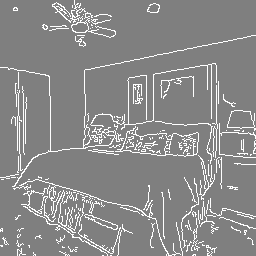
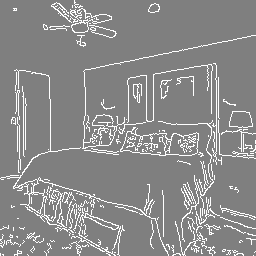

1
2
3
4
5
6
7
8
9
10


,,

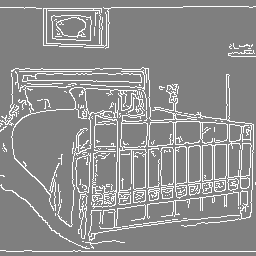
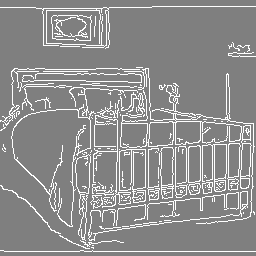
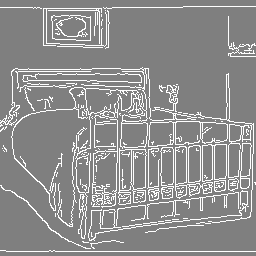

11
12
13
14
15
16
17
18
19
20


,,

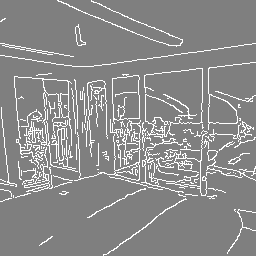
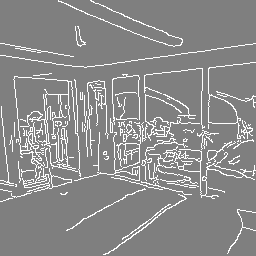
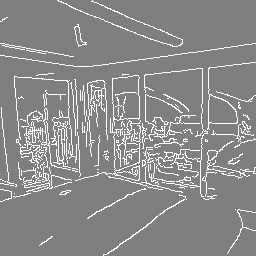

21
22
23
24
25
26
27
28
29
30


,,

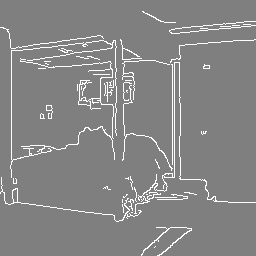
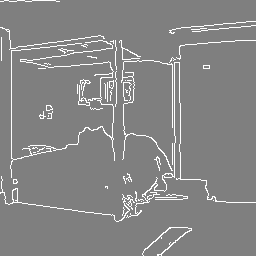
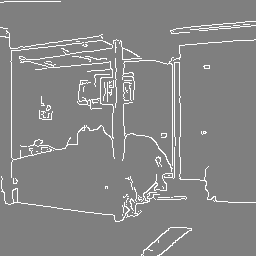

31
32
33
34
35
36
37
38
39
40


,,

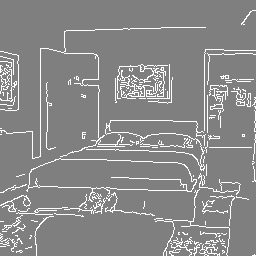
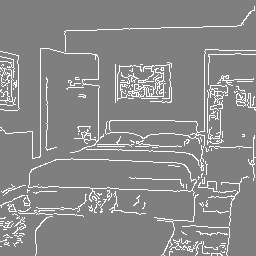
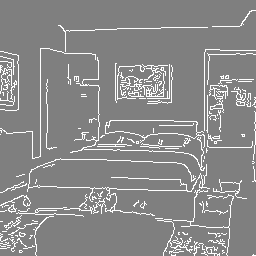

41
42
43
44
45
46
47
48
49
50


,,

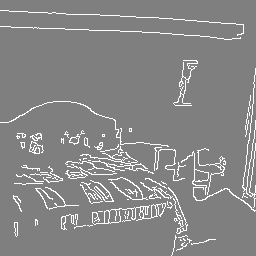
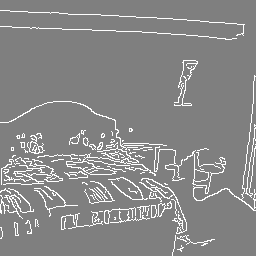
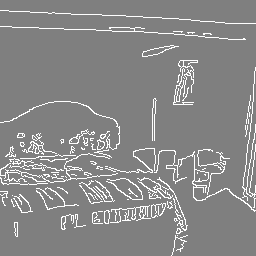

51
52
53
54
55
56
57
58
59
60


,,

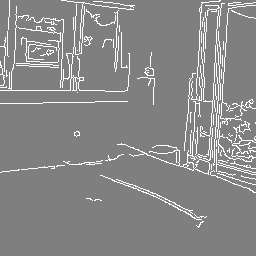
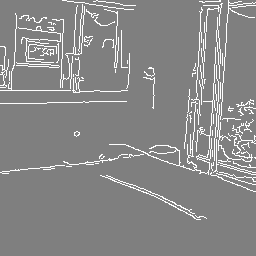
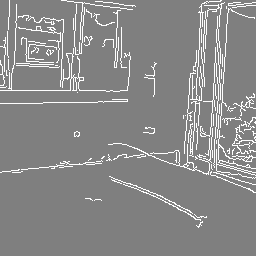

61
62
63
64
65
66
67
68
69
70


,,

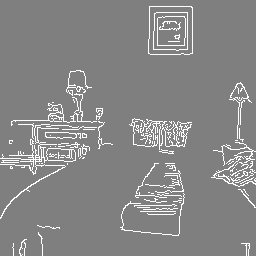
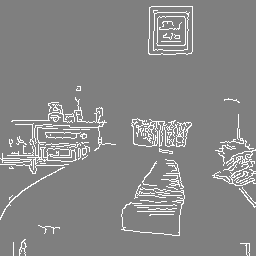
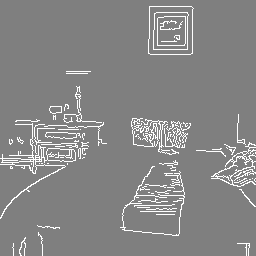

71
72
73
74
75
76
77
78
79
80


,,

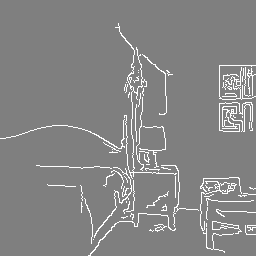
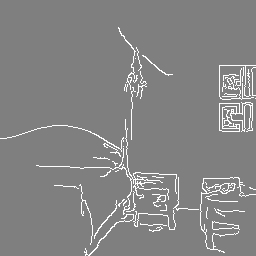
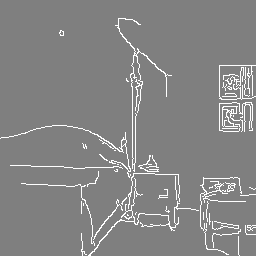

81
82
83
84
85
86
87
88
89
90


,,

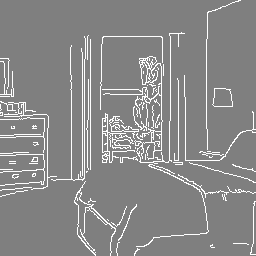
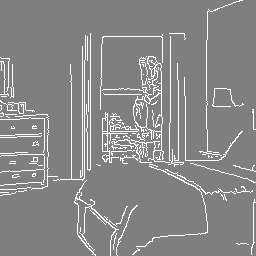
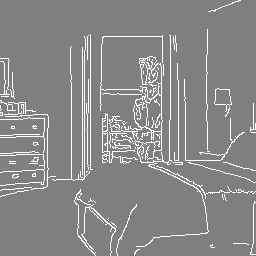

91
92
93
94
95
96
97
98
99


In [69]:
test_path = "results/modulated_bedrooms_9resnet/test_230_generated/images/"
#truth_path = "datasets/agata_bedroom_light_all/test_B/"

lpips_baseline_all = []
mse_baseline_all = []
lpips_all = []
mse_all = []

def pilim(img): 
    return renormalize.from_image(img)

num_imgs = 100
for i in range(num_imgs): 
    print(i)
    img_path = f"bedroom_{i}"
    
    stylespace = (Image.open(
                os.path.join(test_path, img_path+"_stylespace_target.jpg")))
    stylespace = get_edges_canny(stylespace)
    
    test = (Image.open(
                os.path.join(test_path, img_path+"_output_image.jpg")))
    test = get_edges_canny(test)
    
    original = (Image.open(
                os.path.join(test_path, img_path+"_input_image.jpg")))
    original = get_edges_canny(original)
    
    if i%10 == 0: 
        show([(renormalize.as_image(original), renormalize.as_image(test), renormalize.as_image(stylespace))])

    lpips_all.append(torch.squeeze(lpips_metric(original, test)))
    lpips_baseline_all.append(torch.squeeze(lpips_metric(original, stylespace)))
    
    mse_all.append(torch.squeeze(mse_metric(original, test)))
    mse_baseline_all.append(torch.squeeze(mse_metric(original, stylespace)))
     
lpips_baseline_avg = torch.mean(torch.stack(lpips_baseline_all))
mse_basline_avg = torch.mean(torch.stack(mse_baseline_all))  
lpips_avg = torch.mean(torch.stack(lpips_all))
mse_avg = torch.mean(torch.stack(mse_all))


In [68]:
print(f'lpips: {lpips_avg}')
print(f'mse: {mse_avg}')
print(f'lpips baseline: {lpips_baseline_avg}')
print(f'mse baseline: {mse_basline_avg}')

mask = np.ones(test.shape)
lmse = local_error(original.numpy(), test.numpy(), mask, 20, 10)
print(lmse)
lmse = local_error(original.numpy(), stylespace.numpy(), mask, 20, 10)
print(lmse)

lpips: 0.11181814223527908
mse: 0.045896757394075394
lpips baseline: 0.08722785115242004
mse baseline: 0.03061767667531967
256 256
17.89514026230641
256 256
10.811046100065385
